In [384]:
# !pip3 install torch torchvision torchaudio==0.11.0
# !pip3 install pytorch-lightning

In [385]:
# !add-apt-repository -y ppa:savoury1/ffmpeg4
# !add-apt-repository -y ppa:savoury1/ffmpeg5
# !apt-get -qq install -y ffmpeg

In [386]:
# from google.colab import files
# uploaded = files.upload()

In [387]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d sripaadsrinivasan/audio-mnist

In [388]:
# !unzip audio-mnist.zip

In [389]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

1.12.1
0.12.1


In [390]:
import numpy as np
import librosa

In [391]:
# From https://www.kaggle.com/code/padmanabhanporaiyar/audio-mnist-classification-98-accuracy#Create-the-dataset-using-the-defined-function%E2%9C%A8

# A function which return audio file for a mentioned digit
def get_audio_raw(digit=0):
    # Audio Sample Directory
    sample = np.random.randint(1,60)
    # Index of Audio
    index = np.random.randint(1,5)
    
    # Modified file location
    if sample<10:
        file = f"./data/0{sample}/{digit}_0{sample}_{index}.wav"
    else:
        file = f"./data/{sample}/{digit}_{sample}_{index}.wav"

    
    # Get Audio from the location
    data,sample_rate = torchaudio.load(file)
    print(torchaudio.info(file))

    # Return audio
    return data,sample_rate

In [392]:
get_audio_raw(7)

AudioMetaData(sample_rate=48000, num_frames=41090, num_channels=1, bits_per_sample=16, encoding=PCM_S)


(tensor([[-5.4932e-04, -5.4932e-04, -5.4932e-04,  ..., -1.2207e-04,
          -9.1553e-05, -1.8311e-04]]),
 48000)

In [393]:
#The next few functions from https://www.youtube.com/watch?v=3mju52xBFK8

In [394]:
# Play audio
from IPython.display import Audio, display
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

In [395]:
# Plot waveform and spectrogram
import matplotlib.pyplot as plt

def _plot(waveform, sample_rate, title):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    if title == "Waveform":
      axes[c].plot(time_axis, waveform[c], linewidth=1)
      axes[c].grid(True)
    else:
      axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
  figure.suptitle(title)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate):
  _plot(waveform, sample_rate, title="Waveform")

In [396]:
import torchaudio.transforms as T

# AUDIO FEATURE EXTRACTIONS
# Spectrogram: To get the frequency make-up of an audio signal as it varies with time, you can use Spectrogram.
# librosa is a python package for music and audio analysis.
def plot_spectrogram(waveform):
  n_fft = 1024
  win_length = None
  hop_length = 512

  # define transformation
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_length,
      hop_length=hop_length,
      center=True,
      pad_mode="reflect",
      power=2.0,
  )
  # Perform transformation
  spec = spectrogram(waveform).squeeze(0)

  fig, axs = plt.subplots(1, 1)
  axs.set_title('T.Spectrogram')
  axs.set_ylabel('freq_bin')
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect='auto')
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

In [397]:
from torch.utils.data import Dataset
import os
import pathlib
import yaml

class Cache():
  def __init__(self, file, fetchFunction):
    self._file = file
    self._fetchFunction = fetchFunction

  def _writeCache(self, data):
    with open(self._file, 'w') as wf:
      yaml.safe_dump(data, wf)

  def _readCache(self):
    with open(self._file, 'r') as f:
      return yaml.safe_load(f)

  def getData(self, invalidate=False):
    if not invalidate:
      if os.path.isfile(self._file):
        return self._readCache()

    data = self._fetchFunction()
    self._writeCache(data)
    return data

class AudioMNIST(Dataset):
  @staticmethod
  def SampleRate():
    return 48000

  def __init__(self, root, device='cpu', transformFunc=(lambda x, y: (x, y)), minLength = 0.5):
    self._root = root
    self._size = 0

    def getFiles():
      # This will be in order of path(str), class(int)
      dataset = []

      for speaker in os.listdir(root):
        subdir = os.path.join(root, speaker)
        if os.path.isdir(subdir):
          for wavfile in os.listdir(subdir):
            digit = int(wavfile[0])
            fullPath = os.path.join(root, speaker, wavfile)
            info = torchaudio.info(fullPath)
            sampleRate, frames = info.sample_rate, info.num_frames
            if frames / sampleRate >= minLength:
              dataset.append((fullPath, digit))

      return sorted(dataset, key=lambda entry: entry[0])

    self.cache = Cache(
      os.path.join(root, 'pathClasses.cache'), 
      getFiles
    )

    self._fileInfo = self.cache.getData(invalidate=False)

    self.device = device
    self.transformFunc = transformFunc

    return

  def __getitem__(self, index):
    filePath, digitClass = self._fileInfo[index]
    # print(f'Loading {filePath} for class {digitClass}')
    waveform, sampleRate = torchaudio.load(str(filePath))
    # print(self.device)
    waveform = waveform.to(self.device)
    waveform, sampleRate = self.transformFunc(waveform, sampleRate)
    return waveform, sampleRate, int(digitClass)

  def __len__(self):
    return len(self._fileInfo)


  def get_random_digit(self, dClass=0):
    numFiles = len(self)

    startIdx = np.random.randint(0, numFiles)

    filePath, digitClass = self._fileInfo[startIdx]
    while digitClass != dClass:
      startIdx += 2
      if startIdx > numFiles:
        startIdx = 0
      filePath, digitClass = self._fileInfo[startIdx]

    return self[startIdx]

In [398]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
from torch.optim import AdamW, Adam
import random

SEED = 541

random.seed(SEED)
torch.manual_seed(SEED)

In [399]:
torch.cuda.is_available()

True

In [400]:
# Hyperparameters
inputAudioChannels = 1
audioWindowSize = 4096

latentDims = 400

learning_rate = 3e-3

batch_size = 256

In [401]:
# From https://stackoverflow.com/questions/59912850/autoencoder-maxunpool2d-missing-indices-argument

class MaxPool1dIndexExtractor(nn.MaxPool1d):
    def __init__(self, kernel_size, stride, padding=0):
        super().__init__(kernel_size, stride, padding, return_indices=True)
        self.pool_indices = []
        self.last_input_size = []

    def forward(self, x):
        output, indices = super().forward(x)
        self.pool_indices += [indices]
        self.last_input_size = x.size()
        return output

class MaxUnpool1dIndexConsumer(nn.MaxUnpool1d):
    def __init__(self, pooler, kernel_size, stride, padding=0):
        super().__init__(kernel_size, stride, padding)
        self.pooler = pooler

    def forward(self, x):
        indices = self.pooler.pool_indices.pop()
        return super().forward(x, indices, output_size=self.pooler.last_input_size)

In [402]:
import torch.nn as nn

class Encoder(nn.Module):
  def __init__(self, windowSize):
    super().__init__()
    # Test our encoder before we throw it into the class...
    # https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b

    self.finalOutChannels = 16
    self.firstLinearSize = (self.finalOutChannels * (audioWindowSize // (2 * 2 * 2))) // 2
    self.finalOutFeatures = 1024

    self.pool = MaxPool1dIndexExtractor(kernel_size=3, stride=2, padding=1)

    self.encoder = nn.Sequential(
        nn.Conv1d(in_channels=inputAudioChannels, out_channels=4, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(8),
        self.pool,
        nn.Conv1d(in_channels=8, out_channels=self.finalOutChannels, kernel_size=3, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(self.finalOutChannels),
        nn.Flatten(),
        nn.Linear(in_features=self.firstLinearSize, out_features=self.finalOutFeatures),
        # nn.Linear(in_features=self.firstLinearSize // 4, out_features=self.finalOutFeatures),
    )
    # dummy = torch.zeros((1, 1, audioWindowSize)).to(device)

    # tmp = dummy
    # for layer in self.encoder:
    #   tmp = layer(tmp)
    #   print(f'{layer}, Shape: {tmp.shape}')

  def forward(self, x):
    return self.encoder(x)

In [403]:
encoder = Encoder(audioWindowSize)

In [404]:
print(encoder.pool.pool_indices)
for indices in encoder.pool.pool_indices:
    print(indices.squeeze(0).shape)
    print(torch.argmax(indices.squeeze(0)))

[]


In [405]:
class Decoder(nn.Module):
  def __init__(self, encoder):
    super().__init__()
    self.decoder = nn.Sequential(
      nn.Linear(latentDims, encoder.finalOutFeatures),
      nn.ReLU(True),
      # nn.Linear(encoder.finalOutFeatures, encoder.firstLinearSize // 4),
      nn.Linear(in_features=encoder.finalOutFeatures, out_features=encoder.firstLinearSize),
      nn.ReLU(True),
      nn.Unflatten(dim=1, unflattened_size=(encoder.finalOutChannels, encoder.firstLinearSize // encoder.finalOutChannels)),
      nn.BatchNorm1d(encoder.finalOutChannels),
      nn.ReLU(True),
      nn.ConvTranspose1d(in_channels=encoder.finalOutChannels, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
      MaxUnpool1dIndexConsumer(pooler=encoder.pool, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm1d(8),
      nn.ReLU(True),
      nn.ConvTranspose1d(in_channels=8, out_channels=4, kernel_size=5, stride=2, padding=2, output_padding=1),
      nn.ReLU(True),
      nn.ConvTranspose1d(in_channels=4, out_channels=1, kernel_size=5, stride=2, padding=2, output_padding=1)
    )
    # dummy = torch.zeros((1, latentDims))
    # tmp = dummy
    # for layer in self.decoder:
    #   tmp = layer(tmp)
    #   print(f'{layer}, Shape: {tmp.shape}')

  def forward(self, x):
    return self.decoder(x)

In [406]:
decoder = Decoder(encoder)

In [407]:
import torch.nn.functional as F
class VAE(pl.LightningModule):
  def __init__(self, encoder, decoder, latentDims, device='cpu', learning_rate=1e-4):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

    self.latentDims = latentDims

    self.linearMu = nn.Linear(self.encoder.finalOutFeatures, self.latentDims)
    self.linearSigma = nn.Linear(self.encoder.finalOutFeatures, self.latentDims)

    self.N = torch.distributions.Normal(0, 1)
    self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
    self.N.scale = self.N.scale.to(device)
    self.kl = 0

    self.learning_rate = learning_rate

  def encode(self, x):
    x = F.relu(self.encoder(x))
    mu =  self.linearMu(x)
    sigma = torch.exp(self.linearSigma(x))
    z = mu + sigma * self.N.sample(mu.shape)
    self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z

  def forward(self, x):
    return self.encode(x)

  def decode(self, z):
    return self.decoder(z)
  
  def configure_optimizers(self):
    optimizer = Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    X_b = train_batch[0]
    z = self.forward(X_b)   
    x_hat = self.decoder(z)

    # loss = F.mse_loss(x_hat, X_b)
    loss = ((X_b - x_hat)**2).sum() + self.kl

    return {
      'loss': loss,
      'log': {
        'train_loss': loss
      }             
    }

  def training_epoch_end(self, outputs):
    avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
    self.logger.experiment.add_scalar('Loss/Train', avg_loss, self.current_epoch)

  def validation_step(self, val_batch, batch_idx):
    X_b = val_batch[0]
    z = self.forward(X_b)   
    x_hat = self.decoder(z)

    # loss = F.mse_loss(x_hat, X_b)
    loss = ((X_b - x_hat)**2).sum() + self.kl
    self.log('val_loss', loss)
    return {
      'loss': loss,
      'log': {
        'val_loss': loss,
      }
    }

  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
    self.logger.experiment.add_scalar('Loss/Val', avg_loss, self.current_epoch)

In [408]:
import torch.nn.functional as F
class StandardAE(pl.LightningModule):
  def __init__(self, encoder, decoder, latentDims, device='cpu', learning_rate=1e-4):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

    self.latentDims = latentDims

    self.linearFinal = nn.Linear(self.encoder.finalOutFeatures, self.latentDims)

    self.N = torch.distributions.Normal(0, 1)
    self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
    self.N.scale = self.N.scale.to(device)
    self.kl = 0

    self.learning_rate = learning_rate

  def encode(self, x):
    x = F.relu(self.encoder(x))
    z =  self.linearFinal(x)
    return z

  def forward(self, x):
    return self.encode(x)

  def decode(self, z):
    return self.decoder(z)
  
  def configure_optimizers(self):
    optimizer = Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    X_b = train_batch[0]
    z = self.forward(X_b)   
    x_hat = self.decoder(z)

    loss = F.mse_loss(x_hat, X_b)
    # loss = ((X_b - x_hat)**2).sum() + self.kl
    self.log('train_loss', loss)
    return {
      'loss': loss,
      'log': {
        'train_loss': loss
      }             
    }
  
  def training_epoch_end(self, outputs):
    avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
    self.logger.experiment.add_scalar('Loss/Train', avg_loss, self.current_epoch)

  def validation_step(self, val_batch, batch_idx):
    X_b = val_batch[0]
    z = self.forward(X_b)   
    x_hat = self.decoder(z)

    loss = F.mse_loss(x_hat, X_b)
    # loss = ((X_b - x_hat)**2).sum() + self.kl
    self.log('val_loss', loss)
    return {
      'loss': loss,
      'log': {
        'val_loss': loss,
      }
    }

  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
    self.logger.experiment.add_scalar('Loss/Val', avg_loss, self.current_epoch)

In [409]:
accelerator = 'cuda'

device = torch.device('cuda') if accelerator == 'cuda' and torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [410]:
class AudioTransform():
  def __init__(self, orig_freq, new_freq, outputWindowSize, device):
    self.resampler = torchaudio.transforms.Resample(orig_freq, new_freq, rolloff=0.8).to(device)
    self.orig_freq = orig_freq
    self.new_freq = new_freq
    self.device = device
    self.windowSize = outputWindowSize

  def __call__(self, x, rate):
    # print(x.shape)
    resampled = self.resampler(x)
    numSamples = resampled.shape[1]
    # print(numSamples)
    centerSample = numSamples // 2
    halfRange = self.windowSize // 2
    range = [max(0, centerSample - halfRange), min(centerSample + halfRange, numSamples)]
    # print(range)
    cutAudio = resampled[:, range[0]:range[1]]

    cutAudio = cutAudio / torch.max(torch.abs(cutAudio))

    # return addNoise(cutAudio, random.uniform(0.0, 0.04), device), rate // 2
    return cutAudio, self.new_freq


In [411]:
new_rate = 10000
minLength = audioWindowSize / new_rate
cvDataset = AudioMNIST('./data', device=device, transformFunc=AudioTransform(AudioMNIST.SampleRate(), new_rate, audioWindowSize, device))

In [412]:
# torch.cuda.empty_cache()
print(len(cvDataset))

27392


In [413]:
from torch.utils.data import DataLoader,random_split
m=len(cvDataset)
percentVal = 0.20
percentTest = 0.20
valSize, testSize = int(m*percentVal), int(m*percentTest)
trainSize = m - (valSize + testSize)
trainSet, valSet, testSet = random_split(cvDataset, [trainSize, valSize, testSize])

train_loader = torch.utils.data.DataLoader(trainSet, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(valSet, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(testSet, batch_size=batch_size,shuffle=True)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))
print(batch_size)

65
22
22
256


In [414]:
# model = VAE(encoder, decoder, latentDims, device=device, learning_rate=learning_rate/20)
model = StandardAE(encoder, decoder, latentDims, device=device, learning_rate=learning_rate)

In [415]:
for X_b, Y_b, z in train_loader:
  print(model.to(device)(X_b))
  break

tensor([[ 0.0628,  0.2175, -0.0423,  ..., -0.2080,  0.0557, -0.0897],
        [-0.2077,  0.0067, -0.4141,  ..., -0.8365, -0.3609, -0.0916],
        [-0.5119,  0.2418, -0.2391,  ..., -0.0207, -0.0294,  0.2047],
        ...,
        [-0.1000,  0.2241, -0.2795,  ..., -0.1313,  0.0379, -0.2426],
        [ 0.4484,  0.1476,  0.1296,  ..., -0.2483, -0.3694, -0.1656],
        [-0.0302,  0.3004, -0.0387,  ..., -0.2136, -0.1637, -0.2978]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [416]:
# !mkdir ./tb_logs

In [417]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger('./tb_logs', name='AE_Pooling', default_hp_metric=False)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=5e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(accelerator=accelerator, auto_select_gpus=True, logger=logger, callbacks=None, max_epochs=150, log_every_n_steps=1)

Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [418]:
# print(model)
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type    | Params
----------------------------------------
0 | encoder     | Encoder | 4.2 M 
1 | decoder     | Decoder | 4.6 M 
2 | linearFinal | Linear  | 410 K 
----------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params
36.862    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\austi\.conda\envs\ml\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\austi\.conda\envs\ml\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 999: 100%|██████████| 87/87 [00:23<00:00,  3.68it/s, loss=0.0082, v_num=5] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 87/87 [00:24<00:00,  3.59it/s, loss=0.0082, v_num=5]


torch.Size([1])


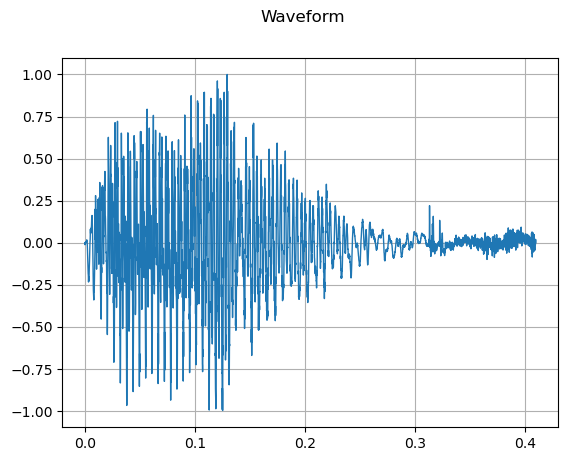

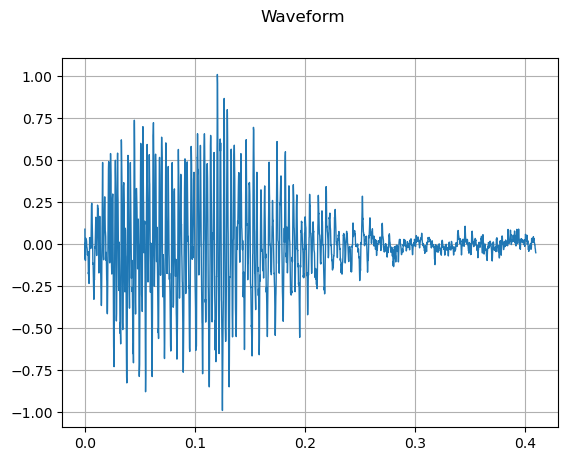

In [431]:
model = model.eval().to(device)
example = 0
for X_b, Y_b, z in train_loader:
  sampleRate = Y_b[0].detach().cpu().item()
  print(z.shape)
  play_audio(X_b[example].detach().cpu(), sampleRate)
  plot_waveform(X_b[example].detach().cpu(), sampleRate)
  encoded = model(X_b)
  decoded = model.decoder(encoded)

  play_audio(decoded[example].detach().cpu(), sampleRate)
  plot_waveform(decoded[example].detach().cpu(), sampleRate)
  break

In [420]:
torch.save({
    'encoder_dict': encoder.state_dict(),
    'decoder_dict': decoder.state_dict(),
    'ae_dict': model.state_dict()
}, 'model_pool.pt')

In [421]:
accelerator = 'cuda'

device = torch.device('cuda') if accelerator == 'cuda' and torch.cuda.is_available() else torch.device('cpu')
new_rate = 10000
minLength = audioWindowSize / new_rate
cvDataset = AudioMNIST('./data', device=device, transformFunc=AudioTransform(AudioMNIST.SampleRate(), new_rate, audioWindowSize, device))

from torch.utils.data import DataLoader,random_split

m=len(cvDataset)
percentVal = 0.20
percentTest = 0.20
valSize, testSize = int(m*percentVal), int(m*percentTest)
trainSize = m - (valSize + testSize)
trainSet, _, testSet = random_split(cvDataset, [trainSize, valSize, testSize])
train_loader = torch.utils.data.DataLoader(trainSet, batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(testSet, batch_size=1,shuffle=True)

print(len(test_loader))

Epoch 116:  46%|████▌     | 40/87 [6:52:07<8:04:14, 618.18s/it, loss=6.25e+04, v_num=4]
5478


In [422]:
loaded_obj = torch.load('model_pool.pt', map_location=device)
encoder_test = Encoder(audioWindowSize)
encoder_test.load_state_dict(loaded_obj['encoder_dict'])
encoder_test.eval()
decoder_test = Decoder(encoder)
decoder_test.load_state_dict(loaded_obj['decoder_dict'])
decoder_test.eval()
model_test = StandardAE(encoder, decoder, latentDims, device)
# model_test = VAE(encoder, decoder, latentDims, device)
model_test.load_state_dict(loaded_obj['ae_dict'])
model_test.eval()

StandardAE(
  (encoder): Encoder(
    (pool): MaxPool1dIndexExtractor(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (encoder): Sequential(
      (0): Conv1d(1, 4, kernel_size=(5,), stride=(2,), padding=(2,))
      (1): ReLU(inplace=True)
      (2): Conv1d(4, 8, kernel_size=(5,), stride=(2,), padding=(2,))
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): MaxPool1dIndexExtractor(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (6): Conv1d(8, 16, kernel_size=(3,), stride=(2,), padding=(1,))
      (7): ReLU(inplace=True)
      (8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=4096, out_features=1024, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=400, out_features=1024, bias=True)
      (1): ReLU(inplace=

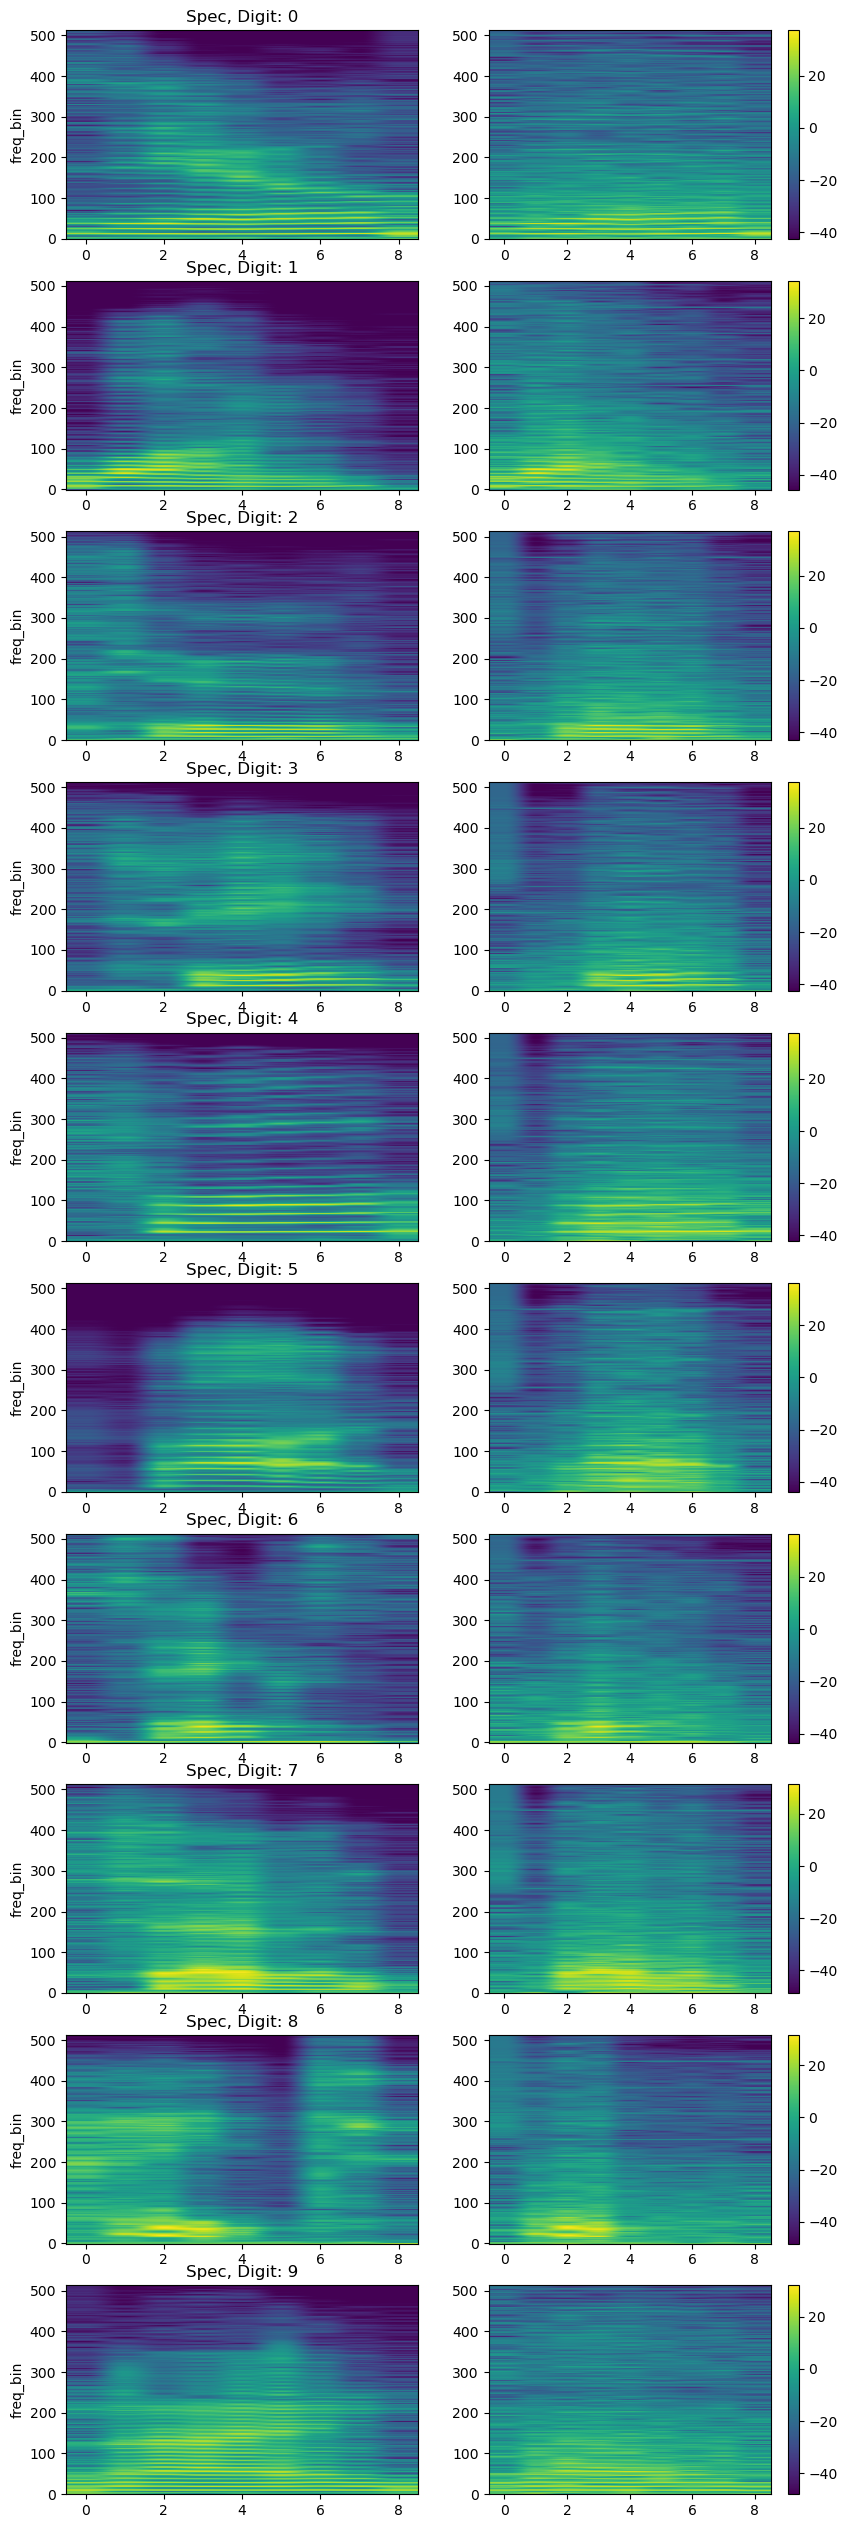

In [423]:
n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation

fig = plt.figure(figsize=(10,32))
for i in range(10):
  waveform_gt, sampleRate, _ = cvDataset.get_random_digit(i)

  encoded = model(waveform_gt.unsqueeze(0))
  decoded = model.decoder(encoded)

  axs = plt.subplot2grid([10, 2], [i, 0])
  axs.set_title(f'Spec, Digit: {i}')
  axs.set_ylabel('freq_bin')
  # axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spectrogram(waveform_gt.squeeze(0).detach().cpu())), origin='lower', aspect='auto')
  axs = plt.subplot2grid((10, 2), (i, 1))
  im = axs.imshow(librosa.power_to_db(spectrogram(decoded.squeeze(0).squeeze(0).detach().cpu())), origin='lower', aspect='auto')
  fig.colorbar(im, ax=axs)

plt.show(block=False)

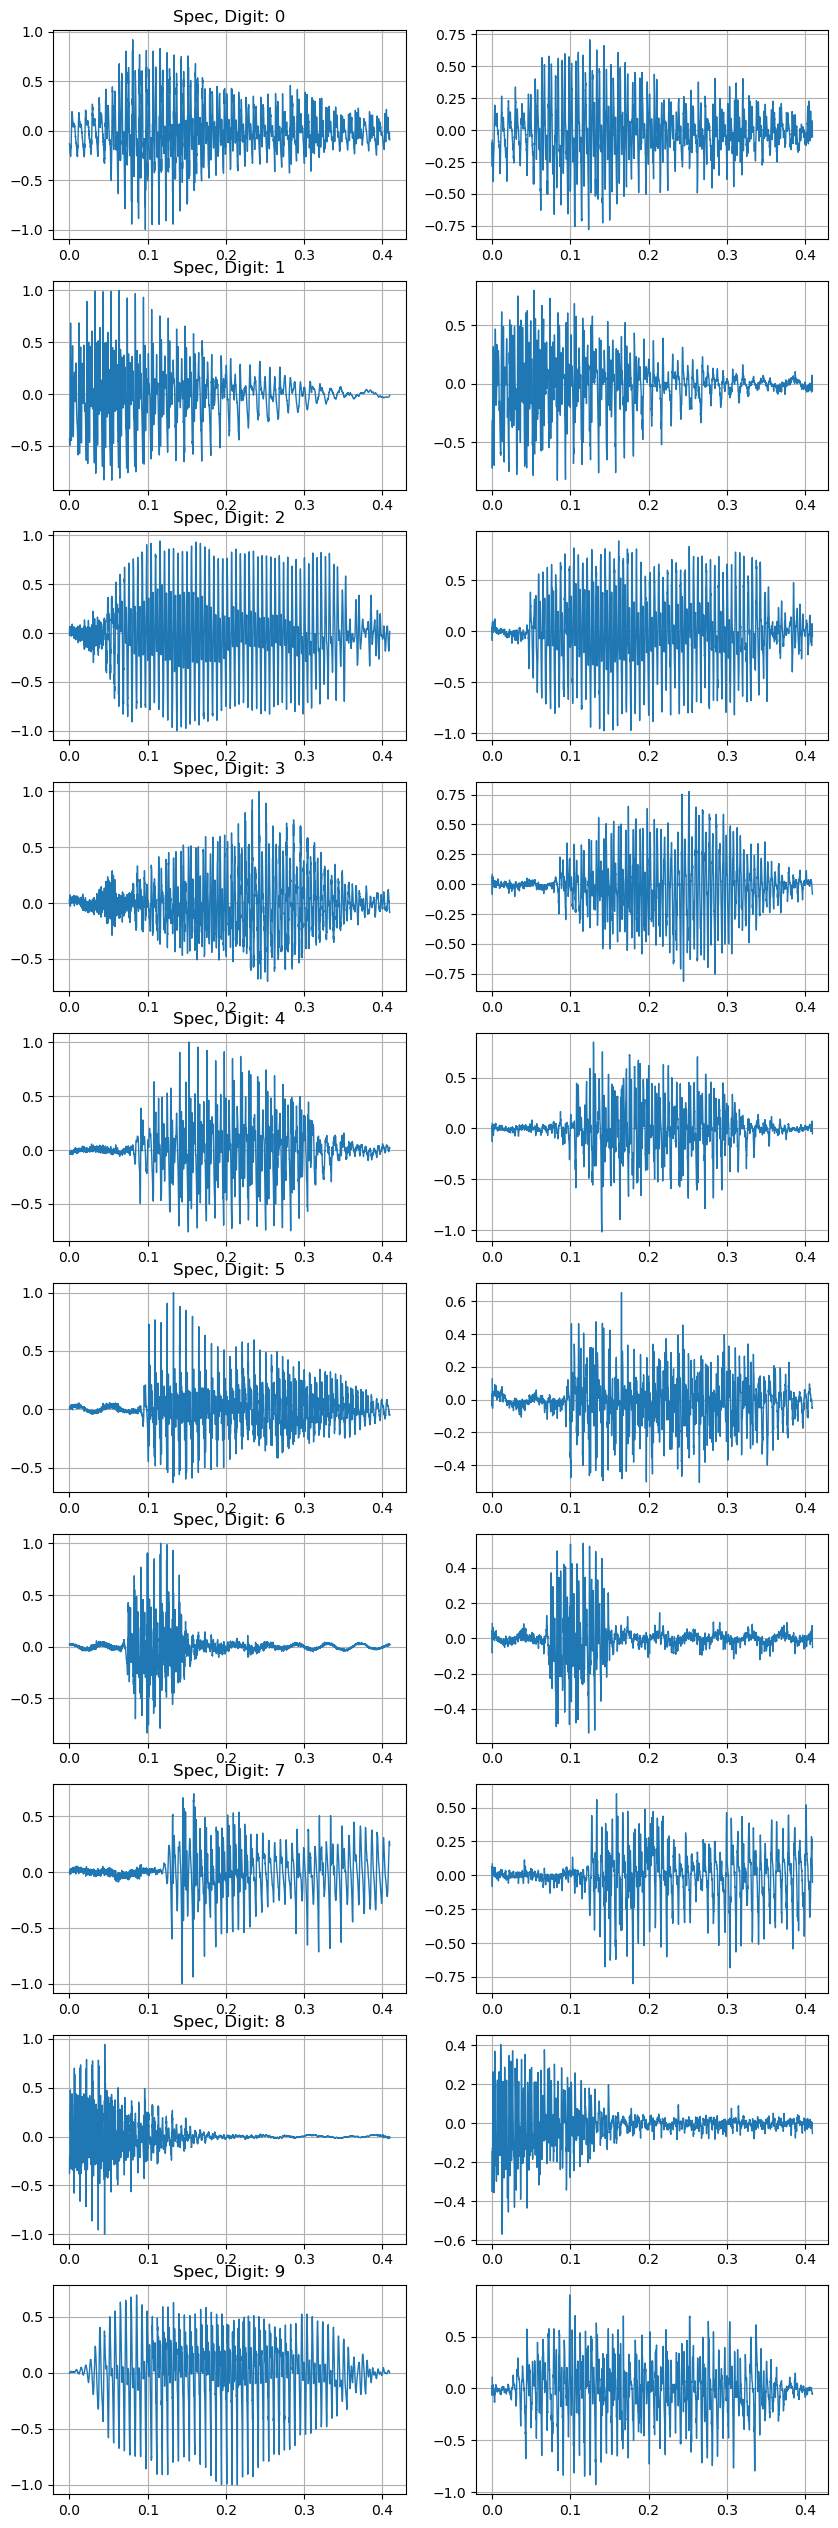

In [424]:
fig = plt.figure(figsize=(10,32))
for i in range(10):
  waveform_gt, sampleRate, _ = cvDataset.get_random_digit(i)

  encoded = model(waveform_gt.unsqueeze(0))
  decoded = model.decoder(encoded)

  num_channels, num_frames = waveform_gt.shape
  time_axis = torch.arange(0, num_frames) / sampleRate

  axs = plt.subplot2grid([10, 2], [i, 0])
  axs.set_title(f'Spec, Digit: {i}')
  axs.plot(time_axis, waveform_gt.squeeze(0).detach().cpu(), linewidth=1)
  axs.grid(True)
  axs = plt.subplot2grid((10, 2), (i, 1))
  axs.plot(time_axis, decoded.squeeze(0).squeeze(0).detach().cpu(), linewidth=1)
  axs.grid(True)
    
plt.show(block=False)

In [425]:
from tqdm import tqdm
import pandas as pd

encoded_samples = []
max_num = 1000
count = 0
for sample in tqdm(train_loader):
    waveform_gt = sample[0]
    label = sample[2]

    encoded = model(waveform_gt)
    # decoded = model.decoder(encoded)

    # Append to list
    encoded = encoded.squeeze(0).detach().cpu().numpy()
    encoded_sample = {f"var_{i}": enc for i, enc in enumerate(encoded)}
    encoded_sample['label'] = label.detach().cpu().item()
    encoded_samples.append(encoded_sample)
    if count > max_num:
        break
    else:
        count += 1
    
encoded_samples = pd.DataFrame(encoded_samples)

  6%|▌         | 1001/16436 [00:04<01:02, 245.24it/s]


<AxesSubplot:xlabel='var_0', ylabel='var_1'>

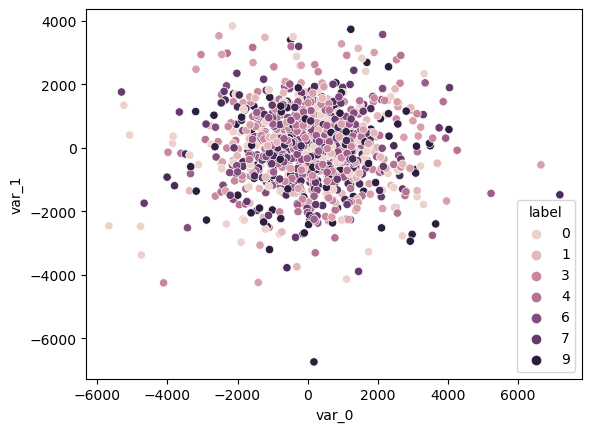

In [426]:
import seaborn as sns

sns.scatterplot(encoded_samples, x='var_0', y='var_1', hue='label')

In [427]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
print(tsne_results)

c:\Users\austi\.conda\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\austi\.conda\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[ 4.863941   -3.2207992 ]
 [ 4.960564   11.299585  ]
 [ 5.0730634   0.40401927]
 ...
 [ 0.91578364  4.2265716 ]
 [ 1.8397659   2.912717  ]
 [ 2.623318    4.1792192 ]]


<AxesSubplot:xlabel='0', ylabel='1'>

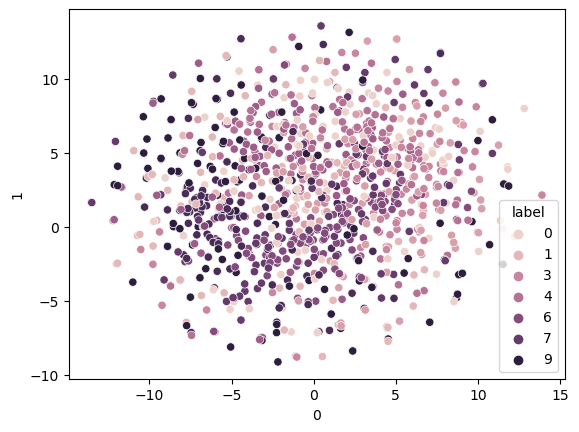

In [428]:
results = pd.DataFrame(tsne_results, columns=['0', '1'])

results['label'] = encoded_samples['label']

sns.scatterplot(results, x='0', y='1', hue='label')